# Loading Libraries

In [1]:
import os
from torch_snippets import *
import cv2

In [2]:
os.chdir("..")

In [3]:
image_path = "dataset\\2.JPG"

# Visualizations

In [4]:
sudoku = read(image_path,1)

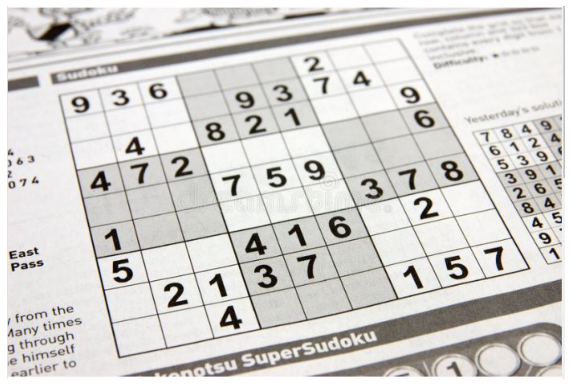

In [5]:
show(sudoku,sz=10)

# Image Preprations

In [6]:
target_height = 450  
target_width = 450

## needs to be square so same height and width

In [7]:
img = read(image_path,1)
img = cv2.resize(img,(target_height,target_width))

In [8]:
imgBlank = np.zeros((target_height,target_width,3),np.uint8) ## Blank image for testing and debugging

In [9]:
def preProcess(img):
    imgGray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) ## Converting image to greyscale
    imgBlur = cv2.GaussianBlur(imgGray, (5,5),1) ## Gaussian Blur
    
    imgThreshold = cv2.adaptiveThreshold(imgBlur,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY_INV, 11,5 )  ## Only 2 values, black and white
    #ret,imgThreshold = cv2.threshold(imgBlur,175,255, type=cv2.THRESH_BINARY)
    return imgThreshold

In [10]:
imgThreshold = preProcess(img)

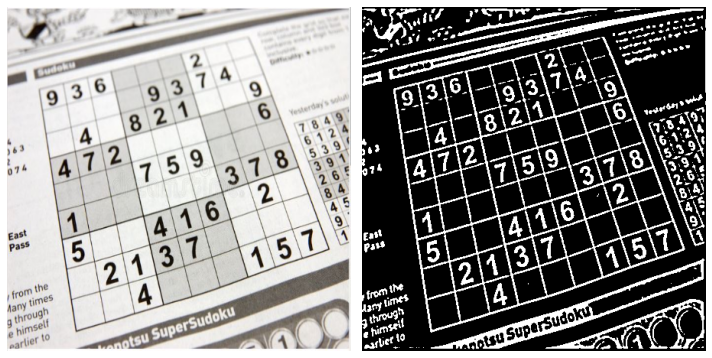

In [11]:
subplots([img,imgThreshold], figsize=10)

# Finding Contours

In [12]:
imgContours = img.copy()
imgBigContour = img.copy()

contours, hierarchy = cv2.findContours(imgThreshold, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

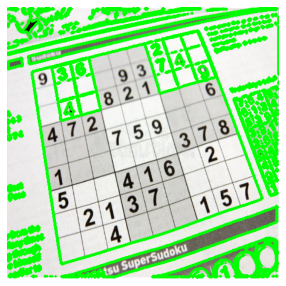

In [13]:
show(cv2.drawContours(imgContours, contours,-1, (0,255,0), 3), sz=5)

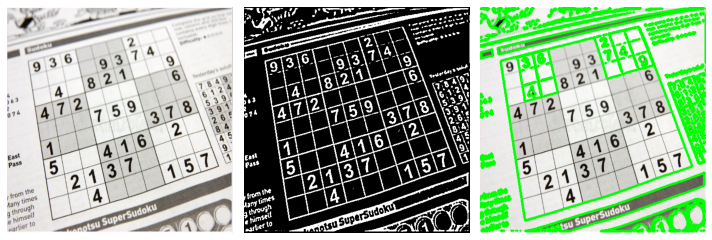

In [14]:
subplots([img,imgThreshold, imgContours], figsize=10)

# Finding Biggest Contour

In [15]:
def biggestContour(contours):
    """
    Find the biggest contour
    
    
    """
    
    biggest = np.array([])
    max_area = 0
    ### Looping through all the contours
    for i in contours:
        area = cv2.contourArea(i)
        ### Checking if for a particular contour, if area is above 50. If not, its mostly noise
        if area > 5:
            peri = cv2.arcLength(i, True) ## perimeter
            approx = cv2.approxPolyDP(i, 0.02*peri , True) #### number of corners
            
            if area>max_area and len(approx) >= 4:   ### ensuring that the captured contour is atleast a square or rectangle
                biggest = approx
                max_area = area
                
    return biggest , max_area

In [16]:
def reorder(myPoints):
    #print(myPoints.shape)
    myPoints = myPoints.reshape((-1,2))   ## removing extra dimension
    myPointsNew = np.zeros((4,1,2), dtype=np.int32)
    add = myPoints.sum(1)  ### adding all the values
    
    myPointsNew[0] = myPoints[np.argmin(add)]   ### origin
    myPointsNew[3] = myPoints[np.argmax(add)]  #### width and height
    
    diff = np.diff(myPoints, axis = 1)
    
    myPointsNew[1] = myPoints[np.argmin(diff)]  
    myPointsNew[2] = myPoints[np.argmax(diff)]
    
    return myPointsNew

In [17]:
biggest, maxArea = biggestContour(contours)

if biggest.size != 0 :
    biggest = reorder(biggest)
    #print(biggest)
    cv2.drawContours(imgBigContour, biggest, -1 , (0,255,0), 10)  ### draw the biggest contour
    
    pts1 = np.float32(biggest)
    pts2 = np.float32([[0,0],[target_width,0],[0,target_height],[target_width,target_height]])
    matrix = cv2.getPerspectiveTransform(pts1,pts2)
    
    ### Create warp perspective and create new image to store the square of sudoku
    imgWarpColored = cv2.warpPerspective(img, matrix, (target_width,target_height))
    imgDetectedDigits = imgBlank.copy()
    imgWarpColored = cv2.cvtColor(imgWarpColored, cv2.COLOR_RGB2GRAY)

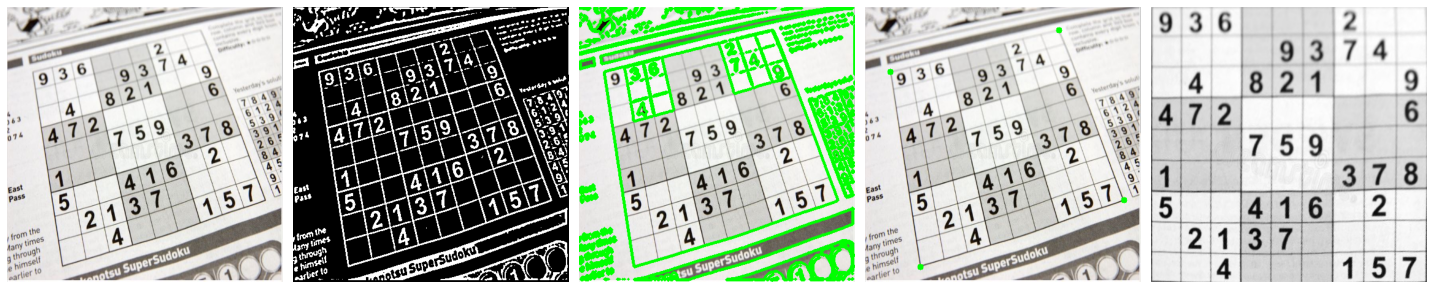

In [18]:
subplots([img,imgThreshold, imgContours, imgBigContour, imgWarpColored], figsize=20)

# Split the image and get each box as seperate image

In [28]:
# from tensorflow.keras.models import load_model
import torch

In [29]:
model_dir = "model"
# model_file_name = "number_detection_model.h5"
model_file_name = "2.pt"
model_path = os.path.join(model_dir, model_file_name)

In [30]:
torch.load(model_path)

ModuleNotFoundError: No module named 'src'

In [21]:
# model = load_model(model_path)

In [22]:
def splitBoxes(img):
    ### splitting the image into 81 small images. Idea is that we will be able to capture every square as they are quite symmetric
    
    rows = np.vsplit(img,9)
    boxes = []
    
    for r in rows:
        cols = np.hsplit(r,9)
        for box in cols:
            boxes.append(box)
            #show(box)
    return boxes


In [23]:
def getPrediction(boxes,model):
    result = []
    for image in boxes:
        ### Prepare image
        img = np.asarray(image)
        img = img[4:img.shape[0]-4, 4:img.shape[1]-4]
        img = cv2.resize(img, (28,28))
        img = img/255
        img = img.reshape(1,28,28,1)
        
        # Get Prediction
        predictions = model.predict(img)
        classIndex = np.argmax(predictions, axis = -1)
        probabilityValue = np.amax(predictions)
        #print(classIndex, probabilityValue)
        
        # Save to Result
        if probabilityValue > 0.7:
            result.append(classIndex[0])
        else:
            result.append(0)
    return result
            

In [24]:
def displayNumbers(img,numbers,color = (0,255,0)):
    secW = int(img.shape[1]/9)
    secH = int(img.shape[0]/9)
    for x in range (0,9):
        for y in range (0,9):
            if numbers[(y*9)+x] != 0 :
                 cv2.putText(img, str(numbers[(y*9)+x]),
                               (x*secW+int(secW/2)-10, int((y+0.8)*secH)), cv2.FONT_HERSHEY_COMPLEX_SMALL,
                            2, color, 2, cv2.LINE_AA)
    return img

In [25]:
imgSolvedDigits = imgBlank.copy()
boxes = splitBoxes(imgWarpColored)
numbers = getPrediction(boxes, model)
imgDetectedDigits = displayNumbers(imgDetectedDigits, numbers, (255,0,255))
# numbers = np.asarray(numbers)
# posArray = np.where(numbers>0,0,1)


1/1 [==============================] - 0s 20ms/step


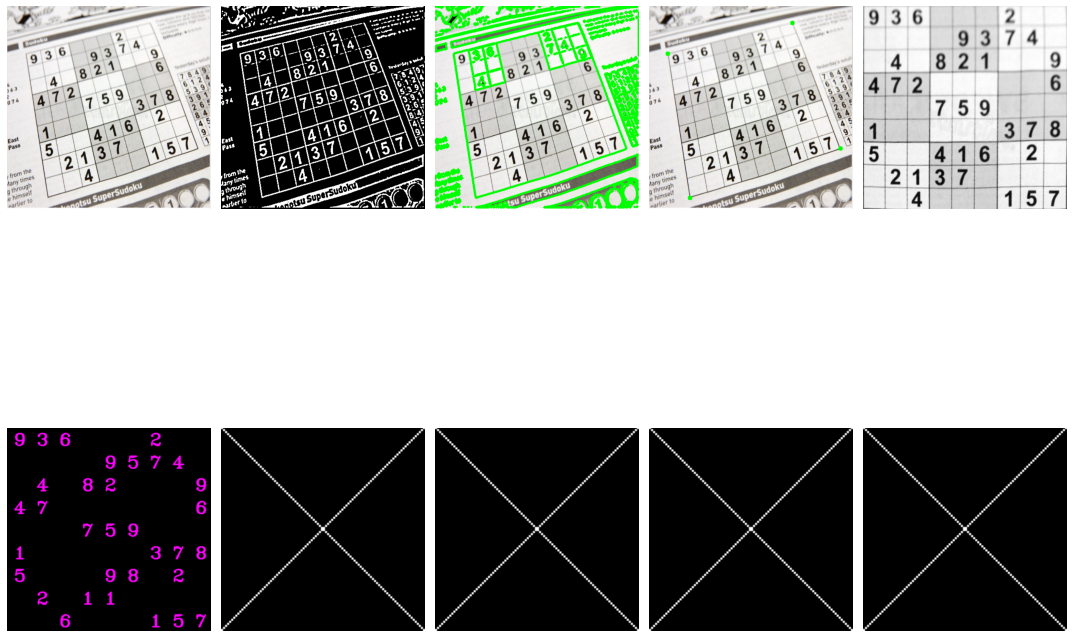

In [26]:
subplots([img,imgThreshold, imgContours, imgBigContour, imgWarpColored, imgDetectedDigits], figsize=15)

In [27]:
numbers

[9,
 3,
 6,
 0,
 0,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 9,
 5,
 7,
 4,
 0,
 0,
 4,
 0,
 8,
 2,
 0,
 0,
 0,
 9,
 4,
 7,
 0,
 0,
 0,
 0,
 0,
 0,
 6,
 0,
 0,
 0,
 7,
 5,
 9,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 3,
 7,
 8,
 5,
 0,
 0,
 0,
 9,
 8,
 0,
 2,
 0,
 0,
 2,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 6,
 0,
 0,
 0,
 1,
 5,
 7]